In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import LSTM, Dense, Dropout, Input, Concatenate
from keras.layers import Attention
from keras.optimizers import Adam
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import optuna



C:\Users\tinku\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Folder path where the Excel files are stored
folder_path = r'C:\Users\tinku\Downloads\Indonesia data'

# Create an empty list to hold dataframes
df_list = []

# Loop through all files in the folder
for file_name in os.listdir(folder_path):
    # Check if the file is an Excel file
    if file_name.endswith('.csv'):
        # Full file path
        file_path = os.path.join(folder_path, file_name)
        # Read the Excel file into a dataframe
        df = pd.read_csv(file_path)
        # Add a new column to keep track of the source file
        df['Source_File'] = file_name
        # Append the dataframe to the list
        df_list.append(df)

# Concatenate all dataframes into one
combined_df = pd.concat(df_list, ignore_index=True)

# Save the combined dataframe to a new Excel file
output_file = 'combined_csv_file.csv'
combined_df.to_csv(output_file, index=False)

print(f"Combined Excel file saved as {output_file}")


Combined Excel file saved as combined_csv_file.csv


In [3]:
combined_df.shape

(1492022, 16)

In [4]:
combined_df.head()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,Source_File
0,-3.0334,133.0733,317.4,1.0,1.0,2000-11-01,151,Terra,MODIS,63,6.2,300.9,8.2,D,0,modis_2000_Indonesia.csv
1,1.2473,109.6869,318.1,1.0,1.0,2000-11-01,328,Terra,MODIS,59,6.2,294.9,9.7,D,0,modis_2000_Indonesia.csv
2,1.3812,100.1306,313.9,3.4,1.7,2000-11-01,329,Terra,MODIS,45,6.2,277.1,50.3,D,0,modis_2000_Indonesia.csv
3,0.8381,101.5897,346.1,2.5,1.5,2000-11-01,329,Terra,MODIS,94,6.2,293.5,186.0,D,0,modis_2000_Indonesia.csv
4,0.8349,101.6121,335.3,2.5,1.5,2000-11-01,329,Terra,MODIS,88,6.2,294.2,115.5,D,0,modis_2000_Indonesia.csv


In [5]:
combined_df.describe()

,latitude,longitude,brightness,scan,track,acq_time,confidence,version,bright_t31,frp,type
count,1.492022e+06,1.492022e+06,1.492022e+06,1.492022e+06,1.492022e+06,1.492022e+06,1.492022e+06,1.492022e+06,1.492022e+06,1.492022e+06,1.492022e+06
mean,-2.208385e+00,1.117623e+02,3.229981e+02,1.526367e+00,1.185908e+00,7.571707e+02,6.507371e+01,8.097273e+00,2.955935e+02,3.461791e+01,1.042042e-01
std,3.099906e+00,9.592345e+00,1.549529e+01,7.338030e-01,2.293886e-01,4.826923e+02,2.255466e+01,1.007446e+01,6.677613e+00,7.121323e+01,4.375258e-01
min,-1.090640e+01,9.506800e+01,3.000000e+02,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,6.030000e+00,2.662000e+02,0.000000e+00,0.000000e+00
25%,-3.280500e+00,1.038381e+02,3.136000e+02,1.000000e+00,1.000000e+00,5.140000e+02,5.100000e+01,6.200000e+00,2.920000e+02,1.020000e+01,0.000000e+00
50%,-2.161000e+00,1.112651e+02,3.199000e+02,1.200000e+00,1.100000e+00,6.110000e+02,6.700000e+01,6.200000e+00,2.958000e+02,1.780000e+01,0.000000e+00
75%,1.227000e-01,1.158054e+02,3.283000e+02,1.700000e+00,1.300000e+00,7.030000e+02,8.100000e+01,6.200000e+00,2.999000e+02,3.500000e+01,0.000000e+00
max,5.833100e+00,1.409773e+02,5.071000e+02,4.800000e+00,2.000000e+00,1.952000e+03,1.000000e+02,6.103000e+01,4.001000e+02,6.647600e+03,3.000000e+00


In [6]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1492022 entries, 0 to 1492021
Data columns (total 16 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   latitude     1492022 non-null  float64
 1   longitude    1492022 non-null  float64
 2   brightness   1492022 non-null  float64
 3   scan         1492022 non-null  float64
 4   track        1492022 non-null  float64
 5   acq_date     1492022 non-null  object 
 6   acq_time     1492022 non-null  int64  
 7   satellite    1492022 non-null  object 
 8   instrument   1492022 non-null  object 
 9   confidence   1492022 non-null  int64  
 10  version      1492022 non-null  float64
 11  bright_t31   1492022 non-null  float64
 12  frp          1492022 non-null  float64
 13  daynight     1492022 non-null  object 
 14  type         1492022 non-null  int64  
 15  Source_File  1492022 non-null  object 
dtypes: float64(8), int64(3), object(5)
memory usage: 182.1+ MB


In [7]:
combined_df.corr()

,latitude,longitude,brightness,scan,track,acq_time,confidence,version,bright_t31,frp,type
latitude,1.000000,-0.579299,-0.010468,0.022523,0.025023,0.188065,0.073392,-0.081309,-0.269348,0.050017,-0.014704
longitude,-0.579299,1.000000,-0.012711,-0.013425,-0.016006,-0.253806,-0.074920,0.077131,0.181356,-0.053279,-0.004458
brightness,-0.010468,-0.012711,1.000000,-0.118367,-0.119406,-0.262717,0.558238,-0.021924,0.421941,0.643792,0.043077
scan,0.022523,-0.013425,-0.118367,1.000000,0.981836,-0.036957,-0.112984,-0.014287,-0.242348,0.265029,0.024745
track,0.025023,-0.016006,-0.119406,0.981836,1.000000,-0.036637,-0.112104,-0.015279,-0.247088,0.260695,0.029186
acq_time,0.188065,-0.253806,-0.262717,-0.036957,-0.036637,1.000000,0.114521,-0.016083,-0.391391,-0.030232,0.114514
confidence,0.073392,-0.074920,0.558238,-0.112984,-0.112104,0.114521,1.000000,-0.012580,0.144912,0.299034,0.040290
version,-0.081309,0.077131,-0.021924,-0.014287,-0.015279,-0.016083,-0.012580,1.000000,0.026679,-0.023102,0.013484
bright_t31,-0.269348,0.181356,0.421941,-0.242348,-0.247088,-0.391391,0.144912,0.026679,1.000000,0.075375,-0.079486
frp,0.050017,-0.053279,0.643792,0.265029,0.260695,-0.030232,0.299034,-0.023102,0.075375,1.000000,0.075499


In [8]:
combined_df.dropna()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type,Source_File
0,-3.0334,133.0733,317.4,1.0,1.0,2000-11-01,151,Terra,MODIS,63,6.20,300.9,8.2,D,0,modis_2000_Indonesia.csv
1,1.2473,109.6869,318.1,1.0,1.0,2000-11-01,328,Terra,MODIS,59,6.20,294.9,9.7,D,0,modis_2000_Indonesia.csv
2,1.3812,100.1306,313.9,3.4,1.7,2000-11-01,329,Terra,MODIS,45,6.20,277.1,50.3,D,0,modis_2000_Indonesia.csv
3,0.8381,101.5897,346.1,2.5,1.5,2000-11-01,329,Terra,MODIS,94,6.20,293.5,186.0,D,0,modis_2000_Indonesia.csv
4,0.8349,101.6121,335.3,2.5,1.5,2000-11-01,329,Terra,MODIS,88,6.20,294.2,115.5,D,0,modis_2000_Indonesia.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1492017,-3.8727,122.3917,309.5,1.0,1.0,2023-12-31,1352,Terra,MODIS,78,61.03,294.2,6.9,N,2,modis_2023_Indonesia.csv
1492018,-2.8262,122.1748,303.9,1.0,1.0,2023-12-31,1352,Terra,MODIS,4,61.03,281.1,6.6,N,2,modis_2023_Indonesia.csv
1492019,0.5582,123.9556,306.5,1.3,1.1,2023-12-31,1353,Terra,MODIS,68,61.03,292.0,8.5,N,0,modis_2023_Indonesia.csv
1492020,0.6945,117.5580,308.2,1.0,1.0,2023-12-31,1813,Aqua,MODIS,74,61.03,286.7,7.4,N,0,modis_2023_Indonesia.csv


In [9]:
duplicates = combined_df[combined_df.duplicated()]
print("Duplicates:\n", duplicates)

Duplicates:
 Empty DataFrame
Columns: [latitude, longitude, brightness, scan, track, acq_date, acq_time, satellite, instrument, confidence, version, bright_t31, frp, daynight, type, Source_File]
Index: []


In [10]:
len(duplicates)

0

In [11]:
if not duplicates.empty:
    print("Duplicate rows found:")
    print(duplicates)
else:
    print("No duplicate rows found.")

No duplicate rows found.


In [31]:
# Load your dataset 
df = pd.read_csv('combined_csv_file.csv')

# Feature selection and preprocessing
df = df[['acq_date', 'confidence']]  # Use 'acq_date' and 'confidence'
df['acq_date'] = pd.to_datetime(df['acq_date'])
df['month'] = df['acq_date'].dt.month
df['year'] = df['acq_date'].dt.year
df['day'] = df['acq_date'].dt.day

# Group data by year, month, day and count the fire hotspots
daily_fire_data = df.groupby([df['year'], df['month'], df['day']]).size().reset_index(name='fire_hotspot_count')
daily_fire_data['acq_date'] = pd.to_datetime(daily_fire_data[['year', 'month', 'day']])



In [33]:
daily_fire_data.head()

,year,month,day,fire_hotspot_count,acq_date
0,2000,11,1,40,2000-11-01
1,2000,11,2,43,2000-11-02
2,2000,11,3,3,2000-11-03
3,2000,11,4,16,2000-11-04
4,2000,11,5,12,2000-11-05


In [34]:
daily_fire_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8365 entries, 0 to 8364
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   year                8365 non-null   int64         
 1   month               8365 non-null   int64         
 2   day                 8365 non-null   int64         
 3   fire_hotspot_count  8365 non-null   int64         
 4   acq_date            8365 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(4)
memory usage: 326.9 KB


In [35]:
daily_fire_data.describe()

,year,month,day,fire_hotspot_count
count,8365.000000,8365.000000,8365.000000,8365.000000
mean,2011.975971,6.571668,15.709863,178.364854
std,6.654827,3.451382,8.784203,381.762405
min,2000.000000,1.000000,1.000000,1.000000
25%,2006.000000,4.000000,8.000000,18.000000
50%,2012.000000,7.000000,16.000000,44.000000
75%,2018.000000,10.000000,23.000000,144.000000
max,2023.000000,12.000000,31.000000,5812.000000


In [36]:
daily_fire_data.corr()

,year,month,day,fire_hotspot_count
year,1.000000,-0.020453,0.001715,-0.104849
month,-0.020453,1.000000,0.007191,0.196983
day,0.001715,0.007191,1.000000,0.000537
fire_hotspot_count,-0.104849,0.196983,0.000537,1.000000


In [32]:
# Split into train (2010-2020) and test (2021-2023)
train_data = daily_fire_data[daily_fire_data['year'] <= 2020]
test_data_2021 = daily_fire_data[daily_fire_data['year'] == 2021]
test_data_2022 = daily_fire_data[daily_fire_data['year'] == 2022]
test_data_2023 = daily_fire_data[daily_fire_data['year'] == 2023]


# Normalize the training data
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['fire_hotspot_count']])

# LSTM Model 

In [13]:
# Function to create sequences
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Optuna objective function
def objective(trial):
    # Define the search space
    lstm_units = trial.suggest_int("lstm_units", 10, 100)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    epochs = trial.suggest_int("epochs", 10, 50)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    time_step = trial.suggest_int("time_step", 1, 10)
     
    
    # Prepare the data with the suggested time_step
    X_train, y_train = create_sequences(train_scaled, time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, input_shape=(time_step, 1)))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(50))
    model.add(Dense(1))
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=30, batch_size=batch_size, verbose=0)
    
    # Validation: use the last 20% of the training data
    val_split = 0.2
    val_size = int(X_train.shape[0] * val_split)
    X_val, y_val = X_train[-val_size:], y_train[-val_size:]
    y_pred = model.predict(X_val)
    
    # Calculate RMSE for validation
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Run 50 trials for optimization

# Display best parameters and RMSE
print("Best Trial:")
print(f"  RMSE: {study.best_value}")
print(f"  Params: {study.best_params}")



[I 2024-11-29 14:51:18,236] A new study created in memory with name: no-name-3bb0c389-9d79-4628-96b6-c5c0351a3e46




46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 14:52:42,353] Trial 0 finished with value: 0.02467249053194493 and parameters: {'lstm_units': 33, 'dropout_rate': 0.178480883687853, 'learning_rate': 1.690239654364121e-05, 'epochs': 47, 'batch_size': 16, 'time_step': 6}. Best is trial 0 with value: 0.02467249053194493.


46/46 [==============================] - 1s 2ms/step


[I 2024-11-29 14:53:13,130] Trial 1 finished with value: 0.02227457598528632 and parameters: {'lstm_units': 32, 'dropout_rate': 0.2287660736308404, 'learning_rate': 0.00032884033037494306, 'epochs': 38, 'batch_size': 32, 'time_step': 2}. Best is trial 1 with value: 0.02227457598528632.


46/46 [==============================] - 1s 4ms/step


[I 2024-11-29 14:53:47,810] Trial 2 finished with value: 0.02242588086587895 and parameters: {'lstm_units': 69, 'dropout_rate': 0.45789022950295133, 'learning_rate': 0.001515923385176895, 'epochs': 37, 'batch_size': 64, 'time_step': 8}. Best is trial 1 with value: 0.02227457598528632.


46/46 [==============================] - 1s 4ms/step


[I 2024-11-29 14:54:55,793] Trial 3 finished with value: 0.022515488385464914 and parameters: {'lstm_units': 77, 'dropout_rate': 0.41489460087738605, 'learning_rate': 0.000763199725501702, 'epochs': 40, 'batch_size': 32, 'time_step': 9}. Best is trial 1 with value: 0.02227457598528632.


46/46 [==============================] - 1s 2ms/step


[I 2024-11-29 14:55:10,514] Trial 4 finished with value: 0.028134121799956696 and parameters: {'lstm_units': 15, 'dropout_rate': 0.35795034813057747, 'learning_rate': 6.528731188622782e-05, 'epochs': 27, 'batch_size': 64, 'time_step': 1}. Best is trial 1 with value: 0.02227457598528632.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 14:55:37,223] Trial 5 finished with value: 0.026189744208902306 and parameters: {'lstm_units': 24, 'dropout_rate': 0.46164607099222155, 'learning_rate': 3.930282493110754e-05, 'epochs': 33, 'batch_size': 64, 'time_step': 8}. Best is trial 1 with value: 0.02227457598528632.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 14:56:01,991] Trial 6 finished with value: 0.022135791113020175 and parameters: {'lstm_units': 12, 'dropout_rate': 0.25350353893172883, 'learning_rate': 0.0043143715916425145, 'epochs': 40, 'batch_size': 64, 'time_step': 7}. Best is trial 6 with value: 0.022135791113020175.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 14:56:49,491] Trial 7 finished with value: 0.024966936067076503 and parameters: {'lstm_units': 28, 'dropout_rate': 0.39569565002801244, 'learning_rate': 4.9484328326431034e-05, 'epochs': 24, 'batch_size': 32, 'time_step': 8}. Best is trial 6 with value: 0.022135791113020175.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 14:57:10,954] Trial 8 finished with value: 0.02263518294266662 and parameters: {'lstm_units': 20, 'dropout_rate': 0.108077791392662, 'learning_rate': 0.00025621613429879683, 'epochs': 27, 'batch_size': 64, 'time_step': 5}. Best is trial 6 with value: 0.022135791113020175.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 14:58:10,733] Trial 9 finished with value: 0.022073308816795294 and parameters: {'lstm_units': 57, 'dropout_rate': 0.48791337876536134, 'learning_rate': 8.495618402819347e-05, 'epochs': 26, 'batch_size': 16, 'time_step': 2}. Best is trial 9 with value: 0.022073308816795294.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 14:59:27,578] Trial 10 finished with value: 0.022181130221370852 and parameters: {'lstm_units': 99, 'dropout_rate': 0.32239565525695396, 'learning_rate': 0.0001746761674973833, 'epochs': 11, 'batch_size': 16, 'time_step': 3}. Best is trial 9 with value: 0.022073308816795294.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:00:44,933] Trial 11 finished with value: 0.026388131666065223 and parameters: {'lstm_units': 51, 'dropout_rate': 0.25274447097998953, 'learning_rate': 0.008181809163698404, 'epochs': 18, 'batch_size': 16, 'time_step': 5}. Best is trial 9 with value: 0.022073308816795294.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:01:58,579] Trial 12 finished with value: 0.02127669308649577 and parameters: {'lstm_units': 50, 'dropout_rate': 0.2848789101045246, 'learning_rate': 0.009579716059138167, 'epochs': 48, 'batch_size': 16, 'time_step': 4}. Best is trial 12 with value: 0.02127669308649577.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:03:06,932] Trial 13 finished with value: 0.02356199960359018 and parameters: {'lstm_units': 49, 'dropout_rate': 0.31411721763659334, 'learning_rate': 1.0122672073880522e-05, 'epochs': 48, 'batch_size': 16, 'time_step': 3}. Best is trial 12 with value: 0.02127669308649577.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:04:23,475] Trial 14 finished with value: 0.025780657180315178 and parameters: {'lstm_units': 65, 'dropout_rate': 0.4838748183386612, 'learning_rate': 0.001633794705243864, 'epochs': 20, 'batch_size': 16, 'time_step': 4}. Best is trial 12 with value: 0.02127669308649577.


46/46 [==============================] - 1s 2ms/step


[I 2024-11-29 15:05:12,731] Trial 15 finished with value: 0.027079231928924457 and parameters: {'lstm_units': 43, 'dropout_rate': 0.17998882622235546, 'learning_rate': 0.00012463176259121188, 'epochs': 32, 'batch_size': 16, 'time_step': 1}. Best is trial 12 with value: 0.02127669308649577.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:06:27,277] Trial 16 finished with value: 0.0241677865645705 and parameters: {'lstm_units': 83, 'dropout_rate': 0.37765671184222716, 'learning_rate': 0.0006208871098038444, 'epochs': 18, 'batch_size': 16, 'time_step': 3}. Best is trial 12 with value: 0.02127669308649577.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:07:41,243] Trial 17 finished with value: 0.02196753305795403 and parameters: {'lstm_units': 61, 'dropout_rate': 0.2964630314713772, 'learning_rate': 0.009593482781372176, 'epochs': 44, 'batch_size': 16, 'time_step': 4}. Best is trial 12 with value: 0.02127669308649577.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:09:02,047] Trial 18 finished with value: 0.021967132092028545 and parameters: {'lstm_units': 40, 'dropout_rate': 0.331359722231816, 'learning_rate': 0.008284907866197701, 'epochs': 50, 'batch_size': 16, 'time_step': 6}. Best is trial 12 with value: 0.02127669308649577.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:10:41,225] Trial 19 finished with value: 0.021073573858062557 and parameters: {'lstm_units': 41, 'dropout_rate': 0.3459540437983712, 'learning_rate': 0.0032064191208704385, 'epochs': 49, 'batch_size': 16, 'time_step': 10}. Best is trial 19 with value: 0.021073573858062557.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:11:34,355] Trial 20 finished with value: 0.022422782894455637 and parameters: {'lstm_units': 42, 'dropout_rate': 0.27886949409594136, 'learning_rate': 0.003377574914314774, 'epochs': 43, 'batch_size': 32, 'time_step': 9}. Best is trial 19 with value: 0.021073573858062557.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:13:11,104] Trial 21 finished with value: 0.02056179922476527 and parameters: {'lstm_units': 38, 'dropout_rate': 0.35083114205433424, 'learning_rate': 0.003960775283391918, 'epochs': 50, 'batch_size': 16, 'time_step': 10}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:14:50,259] Trial 22 finished with value: 0.021568546789868744 and parameters: {'lstm_units': 38, 'dropout_rate': 0.35954011747395953, 'learning_rate': 0.0029025312155504216, 'epochs': 46, 'batch_size': 16, 'time_step': 10}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 4ms/step


[I 2024-11-29 15:16:33,442] Trial 23 finished with value: 0.02602580191802096 and parameters: {'lstm_units': 51, 'dropout_rate': 0.41876897092057785, 'learning_rate': 0.0017338590646594108, 'epochs': 50, 'batch_size': 16, 'time_step': 10}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 4ms/step


[I 2024-11-29 15:18:18,635] Trial 24 finished with value: 0.022156281039841123 and parameters: {'lstm_units': 47, 'dropout_rate': 0.34515537198920127, 'learning_rate': 0.0037428622449108954, 'epochs': 43, 'batch_size': 16, 'time_step': 10}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:19:52,508] Trial 25 finished with value: 0.022515486868169333 and parameters: {'lstm_units': 34, 'dropout_rate': 0.21279513553737253, 'learning_rate': 0.005303095158203885, 'epochs': 46, 'batch_size': 16, 'time_step': 9}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:21:24,448] Trial 26 finished with value: 0.022962511407532495 and parameters: {'lstm_units': 56, 'dropout_rate': 0.28761784458014605, 'learning_rate': 0.0007678711020608366, 'epochs': 50, 'batch_size': 16, 'time_step': 7}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 4ms/step


[I 2024-11-29 15:23:01,205] Trial 27 finished with value: 0.022564926090409217 and parameters: {'lstm_units': 75, 'dropout_rate': 0.3935107596816212, 'learning_rate': 0.0019088451012626412, 'epochs': 37, 'batch_size': 16, 'time_step': 7}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:23:50,764] Trial 28 finished with value: 0.021910462310946302 and parameters: {'lstm_units': 21, 'dropout_rate': 0.26970496880485073, 'learning_rate': 0.005970009981801794, 'epochs': 41, 'batch_size': 32, 'time_step': 9}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:25:00,840] Trial 29 finished with value: 0.02264345624184836 and parameters: {'lstm_units': 34, 'dropout_rate': 0.11154865256821689, 'learning_rate': 0.001064233615298861, 'epochs': 47, 'batch_size': 16, 'time_step': 4}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:26:18,409] Trial 30 finished with value: 0.022343434487328544 and parameters: {'lstm_units': 27, 'dropout_rate': 0.30841541579573517, 'learning_rate': 0.003151010235810315, 'epochs': 45, 'batch_size': 16, 'time_step': 6}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:27:58,999] Trial 31 finished with value: 0.02140478646087574 and parameters: {'lstm_units': 39, 'dropout_rate': 0.36315362752092134, 'learning_rate': 0.00229782512263603, 'epochs': 47, 'batch_size': 16, 'time_step': 10}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:29:42,528] Trial 32 finished with value: 0.022478004548541163 and parameters: {'lstm_units': 45, 'dropout_rate': 0.36874706664891893, 'learning_rate': 0.0024834063582865407, 'epochs': 48, 'batch_size': 16, 'time_step': 10}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:31:21,742] Trial 33 finished with value: 0.023326208439579357 and parameters: {'lstm_units': 35, 'dropout_rate': 0.42082285515988854, 'learning_rate': 0.00043254706995837533, 'epochs': 42, 'batch_size': 16, 'time_step': 10}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:32:51,455] Trial 34 finished with value: 0.020911661236205272 and parameters: {'lstm_units': 29, 'dropout_rate': 0.33711309819157087, 'learning_rate': 0.005954515346299169, 'epochs': 34, 'batch_size': 16, 'time_step': 8}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:33:41,081] Trial 35 finished with value: 0.022886296213706515 and parameters: {'lstm_units': 31, 'dropout_rate': 0.3367236452240772, 'learning_rate': 0.006080185945504611, 'epochs': 36, 'batch_size': 32, 'time_step': 8}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:34:09,452] Trial 36 finished with value: 0.02266582343045403 and parameters: {'lstm_units': 20, 'dropout_rate': 0.23923370388358034, 'learning_rate': 0.001116288653914838, 'epochs': 39, 'batch_size': 64, 'time_step': 9}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:35:37,363] Trial 37 finished with value: 0.03619389208195981 and parameters: {'lstm_units': 28, 'dropout_rate': 0.2180155846339162, 'learning_rate': 0.009911648973054007, 'epochs': 33, 'batch_size': 16, 'time_step': 8}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:36:03,030] Trial 38 finished with value: 0.022379727919085598 and parameters: {'lstm_units': 10, 'dropout_rate': 0.44837191684229316, 'learning_rate': 0.005050585061877196, 'epochs': 35, 'batch_size': 64, 'time_step': 7}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 4ms/step


[I 2024-11-29 15:37:01,016] Trial 39 finished with value: 0.022644087998614167 and parameters: {'lstm_units': 54, 'dropout_rate': 0.3881051284340484, 'learning_rate': 0.006048910029108991, 'epochs': 29, 'batch_size': 32, 'time_step': 9}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:38:22,528] Trial 40 finished with value: 0.021875367914178986 and parameters: {'lstm_units': 61, 'dropout_rate': 0.34216379536202074, 'learning_rate': 0.004091210347363269, 'epochs': 40, 'batch_size': 16, 'time_step': 5}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 4ms/step


[I 2024-11-29 15:40:01,134] Trial 41 finished with value: 0.0240499278067759 and parameters: {'lstm_units': 37, 'dropout_rate': 0.3519256678812692, 'learning_rate': 0.0026449104466305376, 'epochs': 48, 'batch_size': 16, 'time_step': 10}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:41:37,095] Trial 42 finished with value: 0.02494885847947893 and parameters: {'lstm_units': 42, 'dropout_rate': 0.31769844067868863, 'learning_rate': 0.0021255181724684695, 'epochs': 45, 'batch_size': 16, 'time_step': 9}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:43:20,685] Trial 43 finished with value: 0.023208490472193293 and parameters: {'lstm_units': 46, 'dropout_rate': 0.4076346885299496, 'learning_rate': 0.0011542581150046677, 'epochs': 50, 'batch_size': 16, 'time_step': 10}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:44:49,321] Trial 44 finished with value: 0.023921959877498518 and parameters: {'lstm_units': 30, 'dropout_rate': 0.4419140066965671, 'learning_rate': 0.006730148640863951, 'epochs': 48, 'batch_size': 16, 'time_step': 8}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:45:15,780] Trial 45 finished with value: 0.025789111065148404 and parameters: {'lstm_units': 15, 'dropout_rate': 0.37220766140452227, 'learning_rate': 2.732200142615881e-05, 'epochs': 10, 'batch_size': 64, 'time_step': 9}. Best is trial 21 with value: 0.02056179922476527.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:46:46,460] Trial 46 finished with value: 0.019777720449503995 and parameters: {'lstm_units': 24, 'dropout_rate': 0.2638082740029352, 'learning_rate': 0.0042230479308905606, 'epochs': 44, 'batch_size': 16, 'time_step': 10}. Best is trial 46 with value: 0.019777720449503995.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:48:09,998] Trial 47 finished with value: 0.02592337244486449 and parameters: {'lstm_units': 25, 'dropout_rate': 0.2653605470254223, 'learning_rate': 0.004460435848980806, 'epochs': 42, 'batch_size': 16, 'time_step': 8}. Best is trial 46 with value: 0.019777720449503995.


46/46 [==============================] - 1s 2ms/step


[I 2024-11-29 15:49:02,886] Trial 48 finished with value: 0.0227975198121692 and parameters: {'lstm_units': 18, 'dropout_rate': 0.3000503937574979, 'learning_rate': 0.007792980264612016, 'epochs': 38, 'batch_size': 16, 'time_step': 2}. Best is trial 46 with value: 0.019777720449503995.


46/46 [==============================] - 1s 3ms/step


[I 2024-11-29 15:49:30,566] Trial 49 finished with value: 0.022861788209714382 and parameters: {'lstm_units': 23, 'dropout_rate': 0.1875752980161908, 'learning_rate': 0.004144039723944068, 'epochs': 44, 'batch_size': 64, 'time_step': 9}. Best is trial 46 with value: 0.019777720449503995.


Best Trial:
  RMSE: 0.019777720449503995
  Params: {'lstm_units': 24, 'dropout_rate': 0.2638082740029352, 'learning_rate': 0.0042230479308905606, 'epochs': 44, 'batch_size': 16, 'time_step': 10}


Epoch 1/44
455/455 [==============================] - 6s 7ms/step - loss: 0.0023
Epoch 2/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0020
Epoch 3/44
455/455 [==============================] - 4s 8ms/step - loss: 0.0020
Epoch 4/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0019
Epoch 5/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0018
Epoch 6/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0018
Epoch 7/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0018
Epoch 8/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0019
Epoch 9/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0017
Epoch 10/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0017
Epoch 11/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0017
Epoch 12/44
455/455 [==============================] - 3s 7ms/step - loss: 0.0017
Epoch 13/44
455/455 [====

C:\Users\tinku\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\tinku\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\tinku\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


11/11 [==============================] - 0s 3ms/step


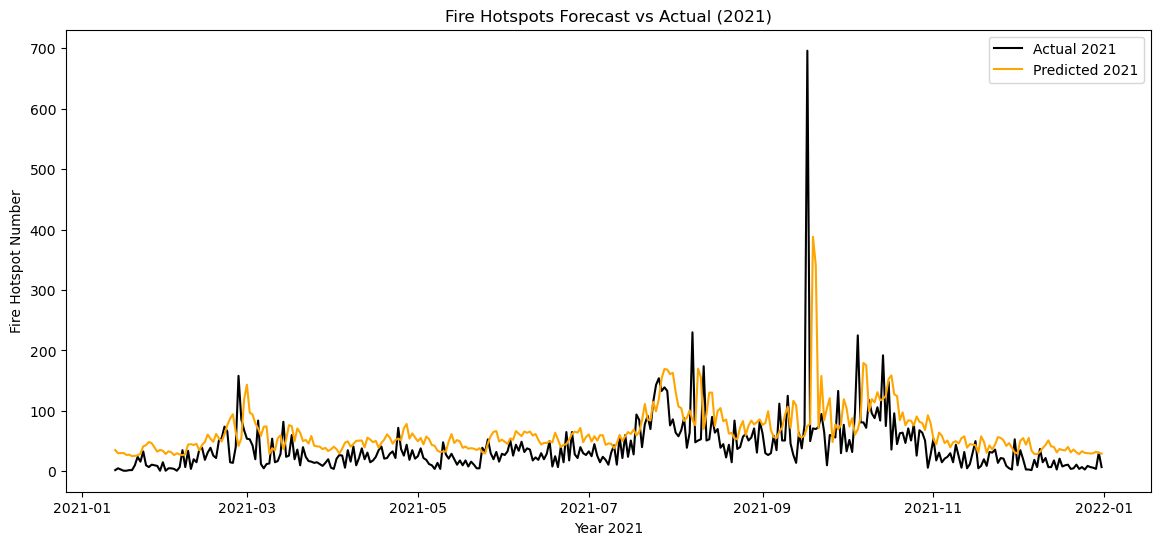

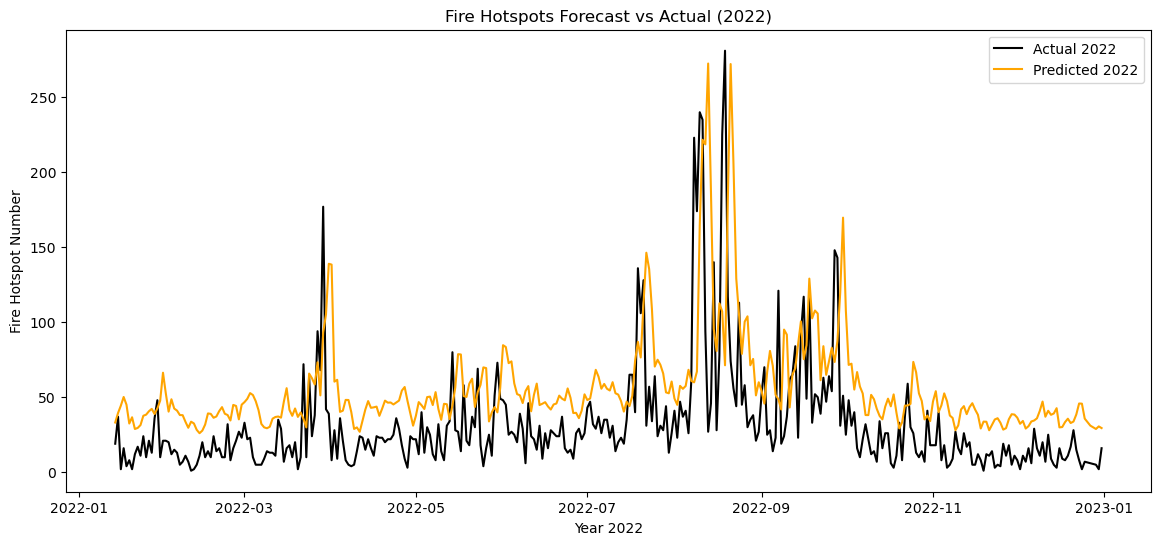

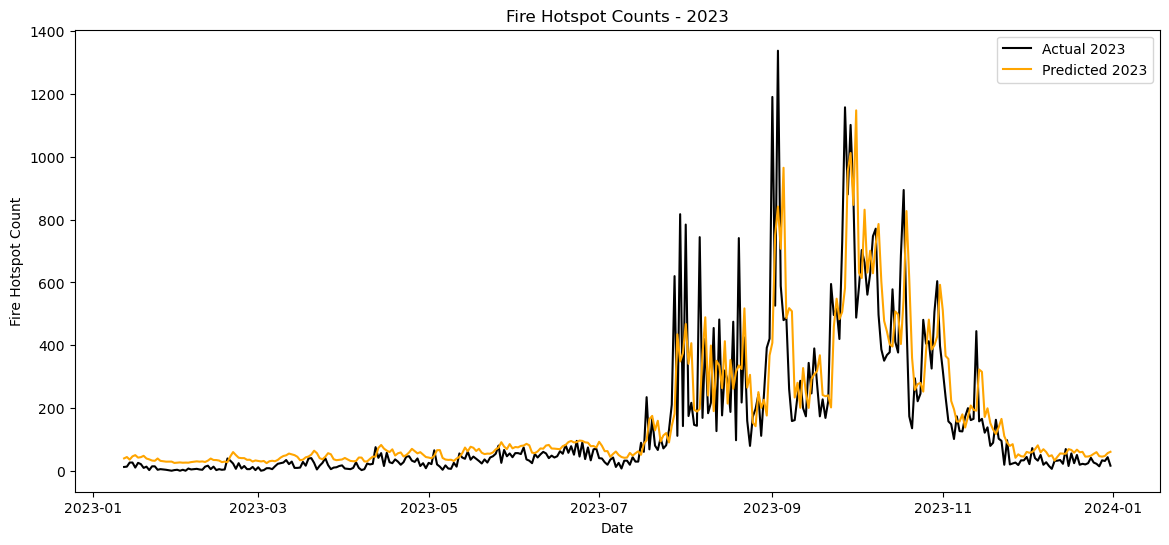

In [14]:
# Extract the best parameters
best_params = study.best_params

# Retrain the final model with the best parameters
time_step = best_params["time_step"]
X_train, y_train = create_sequences(train_scaled, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

final_model = Sequential()
final_model.add(LSTM(best_params["lstm_units"], return_sequences=True, input_shape=(time_step, 1)))
final_model.add(Dropout(best_params["dropout_rate"]))
final_model.add(LSTM(best_params["lstm_units"], return_sequences=False))
final_model.add(Dropout(best_params["dropout_rate"]))
final_model.add(Dense(50))
final_model.add(Dense(1))

optimizer = Adam(learning_rate=best_params["learning_rate"])
final_model.compile(optimizer=optimizer, loss='mean_squared_error')

final_model.fit(X_train, y_train, epochs=best_params["epochs"], batch_size=best_params["batch_size"], verbose=1)

# Test data prediction for 2021 and 2022 and 2023
test_scaled_2021 = scaler.transform(test_data_2021[['fire_hotspot_count']].values)
test_scaled_2022 = scaler.transform(test_data_2022[['fire_hotspot_count']].values)
test_scaled_2023 = scaler.transform(test_data_2023[['fire_hotspot_count']].values)


X_test_2021, y_test_2021 = create_sequences(test_scaled_2021, time_step)
X_test_2022, y_test_2022 = create_sequences(test_scaled_2022, time_step)
X_test_2023, y_test_2023 = create_sequences(test_scaled_2023, time_step)


X_test_2021 = X_test_2021.reshape(X_test_2021.shape[0], X_test_2021.shape[1], 1)
X_test_2022 = X_test_2022.reshape(X_test_2022.shape[0], X_test_2022.shape[1], 1)
X_test_2023 = X_test_2023.reshape(X_test_2023.shape[0], X_test_2023.shape[1], 1)


predicted_2021 = final_model.predict(X_test_2021)
predicted_2022 = final_model.predict(X_test_2022)
predicted_2023 = final_model.predict(X_test_2023)


predicted_2021_unscaled = scaler.inverse_transform(predicted_2021)
predicted_2022_unscaled = scaler.inverse_transform(predicted_2022)
predicted_2023_unscaled = scaler.inverse_transform(predicted_2023)


# Visualization
test_days_2021 = test_data_2021.iloc[time_step + 1:]['acq_date']
test_days_2022 = test_data_2022.iloc[time_step + 1:]['acq_date']
test_days_2023 = test_data_2023.iloc[time_step + 1:]['acq_date']

# Plot actual vs predicted fire hotspot numbers for 2021
plt.figure(figsize=(14, 6))
plt.plot(test_days_2021, test_data_2021['fire_hotspot_count'][time_step + 1:], label='Actual 2021', color='black')
plt.plot(test_days_2021, predicted_2021_unscaled, label='Predicted 2021', color='orange')
plt.title('Fire Hotspots Forecast vs Actual (2021)')
plt.xlabel('Year 2021')
plt.ylabel('Fire Hotspot Number')
plt.legend()
plt.show()

# Plot actual vs predicted fire hotspot numbers for 2022
plt.figure(figsize=(14, 6))
plt.plot(test_days_2022, test_data_2022['fire_hotspot_count'][time_step + 1:], label='Actual 2022', color='black')
plt.plot(test_days_2022, predicted_2022_unscaled, label='Predicted 2022', color='orange')
plt.title('Fire Hotspots Forecast vs Actual (2022)')
plt.xlabel('Year 2022')
plt.ylabel('Fire Hotspot Number')
plt.legend()
plt.show()

# Plot actual vs predicted fire hotspot numbers for 2023
plt.figure(figsize=(14, 6))
plt.plot(test_days_2023, scaler.inverse_transform(y_test_2023.reshape(-1, 1)), label='Actual 2023',  color='black')
plt.plot(test_days_2023, predicted_2023_unscaled, label='Predicted 2023', color='orange')
plt.title('Fire Hotspot Counts - 2023')
plt.xlabel('Date')
plt.ylabel('Fire Hotspot Count')
plt.legend()
plt.show()

In [16]:

# Calculate RMSE for 2021
rmse_2021_LSTM = np.sqrt(mean_squared_error(test_data_2021['fire_hotspot_count'][time_step + 1:], predicted_2021_unscaled))
print(f"RMSE for 2021: {rmse_2021_LSTM}")

# Calculate RMSE for 2022
rmse_2022_LSTM = np.sqrt(mean_squared_error(test_data_2022['fire_hotspot_count'][time_step + 1:], predicted_2022_unscaled))
print(f"RMSE for 2022: {rmse_2022_LSTM}")

# Calculate RMSE for 2022
rmse_2023_LSTM= np.sqrt(mean_squared_error(test_data_2023['fire_hotspot_count'][time_step + 1:], predicted_2023_unscaled))
print(f"RMSE for 2023: {rmse_2023_LSTM}")

RMSE for 2021: 55.6404303261319
RMSE for 2022: 43.632741043535006
RMSE for 2023: 141.56643803378185


## LSTM with Attention Layers

In [37]:
# Create sequences for LSTM
def create_sequences(data, time_step=5):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Attention block
def attention_block(inputs):
    attention_layer = Attention()([inputs, inputs])
    return attention_layer

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    lstm_units = trial.suggest_int("lstm_units", 20, 100)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = trial.suggest_int("epochs", 10, 50)
    time_step = trial.suggest_int("time_step", 3, 10)
    
    # Prepare data with the chosen time_step
    X_train, y_train = create_sequences(train_scaled, time_step)
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
    
    # Build the model
    input_layer = Input(shape=(time_step, 1))
    lstm_out = LSTM(lstm_units, return_sequences=True)(input_layer)
    dropout_1 = Dropout(dropout_rate)(lstm_out)
    attention_out = attention_block(dropout_1)
    lstm_out_2 = LSTM(lstm_units, return_sequences=False)(attention_out)
    dropout_2 = Dropout(dropout_rate)(lstm_out_2)
    dense_1 = Dense(50)(dropout_2)
    output = Dense(1)(dense_1)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)
    
    # Validation on the last 20% of training data
    val_split = 0.2
    val_size = int(X_train.shape[0] * val_split)
    X_val, y_val = X_train[-val_size:], y_train[-val_size:]
    y_pred = model.predict(X_val)
    
    # Calculate RMSE for validation
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# Run Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)  # Perform 50 trials for tuning

# Best trial details
print("Best Trial:")
print(f"  RMSE: {study.best_value}")
print(f"  Params: {study.best_params}")

[I 2024-11-30 17:59:20,293] A new study created in memory with name: no-name-409a998a-e0e4-484d-8a1d-f1905823479c


46/46 [==============================] - 3s 10ms/step


[I 2024-11-30 18:03:17,591] Trial 0 finished with value: 0.023144210023683106 and parameters: {'lstm_units': 33, 'dropout_rate': 0.36203709941134865, 'learning_rate': 0.009018881216557166, 'batch_size': 16, 'epochs': 42, 'time_step': 5}. Best is trial 0 with value: 0.023144210023683106.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 18:05:30,219] Trial 1 finished with value: 0.02396371434527448 and parameters: {'lstm_units': 22, 'dropout_rate': 0.44620954800229906, 'learning_rate': 0.0003294754180699458, 'batch_size': 32, 'epochs': 42, 'time_step': 6}. Best is trial 0 with value: 0.023144210023683106.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 18:06:57,134] Trial 2 finished with value: 0.02208570373634321 and parameters: {'lstm_units': 97, 'dropout_rate': 0.1080266943888395, 'learning_rate': 0.00018351516066007434, 'batch_size': 64, 'epochs': 44, 'time_step': 3}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 10ms/step


[I 2024-11-30 18:10:50,198] Trial 3 finished with value: 0.02338930352915343 and parameters: {'lstm_units': 70, 'dropout_rate': 0.49142134912189006, 'learning_rate': 0.004150733300906473, 'batch_size': 16, 'epochs': 32, 'time_step': 8}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 18:11:58,104] Trial 4 finished with value: 0.02432047938073582 and parameters: {'lstm_units': 50, 'dropout_rate': 0.11586059021855762, 'learning_rate': 0.00010562505716203202, 'batch_size': 16, 'epochs': 10, 'time_step': 6}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 6ms/step


[I 2024-11-30 18:12:44,812] Trial 5 finished with value: 0.022590018008802393 and parameters: {'lstm_units': 94, 'dropout_rate': 0.4578287860902589, 'learning_rate': 2.8748562930825946e-05, 'batch_size': 32, 'epochs': 13, 'time_step': 3}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 9ms/step


[I 2024-11-30 18:16:51,635] Trial 6 finished with value: 0.022358823084189437 and parameters: {'lstm_units': 100, 'dropout_rate': 0.21009457419934227, 'learning_rate': 3.084610892880524e-05, 'batch_size': 16, 'epochs': 36, 'time_step': 6}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 18:18:09,568] Trial 7 finished with value: 0.031044997767544893 and parameters: {'lstm_units': 100, 'dropout_rate': 0.46101256714474637, 'learning_rate': 0.001584176756698461, 'batch_size': 32, 'epochs': 16, 'time_step': 8}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 18:19:28,415] Trial 8 finished with value: 0.02505160975551794 and parameters: {'lstm_units': 28, 'dropout_rate': 0.4130737110767059, 'learning_rate': 0.0001856436077307766, 'batch_size': 64, 'epochs': 19, 'time_step': 7}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 18:21:35,416] Trial 9 finished with value: 0.027148887631896036 and parameters: {'lstm_units': 53, 'dropout_rate': 0.39840321013695024, 'learning_rate': 0.00010732490753868154, 'batch_size': 32, 'epochs': 29, 'time_step': 8}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 12ms/step


[I 2024-11-30 18:24:15,489] Trial 10 finished with value: 0.023783625626017494 and parameters: {'lstm_units': 77, 'dropout_rate': 0.24836416729245664, 'learning_rate': 0.000799133906432544, 'batch_size': 64, 'epochs': 49, 'time_step': 10}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 18:25:28,778] Trial 11 finished with value: 0.022605313887860735 and parameters: {'lstm_units': 85, 'dropout_rate': 0.1093172647642213, 'learning_rate': 1.2233876692558033e-05, 'batch_size': 64, 'epochs': 35, 'time_step': 3}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 18:27:18,091] Trial 12 finished with value: 0.023004132157862827 and parameters: {'lstm_units': 88, 'dropout_rate': 0.20916159832111558, 'learning_rate': 3.985211630488048e-05, 'batch_size': 64, 'epochs': 50, 'time_step': 4}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 9ms/step


[I 2024-11-30 18:31:22,918] Trial 13 finished with value: 0.02268648833256421 and parameters: {'lstm_units': 70, 'dropout_rate': 0.18414094118240398, 'learning_rate': 4.026802150809736e-05, 'batch_size': 16, 'epochs': 39, 'time_step': 5}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 11ms/step


[I 2024-11-30 18:32:54,069] Trial 14 finished with value: 0.025155743325197863 and parameters: {'lstm_units': 100, 'dropout_rate': 0.30198061689672984, 'learning_rate': 1.0801663625596687e-05, 'batch_size': 64, 'epochs': 23, 'time_step': 10}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 18:35:30,498] Trial 15 finished with value: 0.022950095473016213 and parameters: {'lstm_units': 84, 'dropout_rate': 0.16582627384600543, 'learning_rate': 0.00044289530678549453, 'batch_size': 16, 'epochs': 26, 'time_step': 4}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 18:37:02,170] Trial 16 finished with value: 0.023458058249822493 and parameters: {'lstm_units': 63, 'dropout_rate': 0.2470754967231146, 'learning_rate': 6.377789306003526e-05, 'batch_size': 64, 'epochs': 44, 'time_step': 4}. Best is trial 2 with value: 0.02208570373634321.


46/46 [==============================] - 3s 10ms/step


[I 2024-11-30 18:41:03,806] Trial 17 finished with value: 0.02197110589618005 and parameters: {'lstm_units': 43, 'dropout_rate': 0.15384737785398925, 'learning_rate': 1.990786548357004e-05, 'batch_size': 16, 'epochs': 36, 'time_step': 7}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 3s 11ms/step


[I 2024-11-30 18:47:06,065] Trial 18 finished with value: 0.022419789232387695 and parameters: {'lstm_units': 40, 'dropout_rate': 0.14437603817922287, 'learning_rate': 0.0011683399151868113, 'batch_size': 16, 'epochs': 46, 'time_step': 9}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 3s 10ms/step


[I 2024-11-30 18:48:36,924] Trial 19 finished with value: 0.02321628161945289 and parameters: {'lstm_units': 44, 'dropout_rate': 0.3166931979832983, 'learning_rate': 0.00017305579573526097, 'batch_size': 64, 'epochs': 36, 'time_step': 7}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 3s 12ms/step


[I 2024-11-30 18:49:59,727] Trial 20 finished with value: 0.02452338003087319 and parameters: {'lstm_units': 58, 'dropout_rate': 0.2510888104155509, 'learning_rate': 1.887541073282475e-05, 'batch_size': 64, 'epochs': 30, 'time_step': 5}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 3s 13ms/step


[I 2024-11-30 18:55:20,192] Trial 21 finished with value: 0.022742067681022788 and parameters: {'lstm_units': 92, 'dropout_rate': 0.2054665528098032, 'learning_rate': 2.0619575022454064e-05, 'batch_size': 16, 'epochs': 38, 'time_step': 7}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 4s 13ms/step


[I 2024-11-30 18:59:48,749] Trial 22 finished with value: 0.02243642865007434 and parameters: {'lstm_units': 78, 'dropout_rate': 0.1449485961704591, 'learning_rate': 5.964869408438975e-05, 'batch_size': 16, 'epochs': 35, 'time_step': 6}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 6ms/step


[I 2024-11-30 19:03:18,638] Trial 23 finished with value: 0.023236539427964158 and parameters: {'lstm_units': 40, 'dropout_rate': 0.13715015286105547, 'learning_rate': 8.320597956296836e-05, 'batch_size': 16, 'epochs': 39, 'time_step': 9}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 6ms/step


[I 2024-11-30 19:06:18,795] Trial 24 finished with value: 0.02243294077266994 and parameters: {'lstm_units': 94, 'dropout_rate': 0.21398859577410917, 'learning_rate': 1.7932646561866845e-05, 'batch_size': 16, 'epochs': 46, 'time_step': 3}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 19:09:17,120] Trial 25 finished with value: 0.022995814031708712 and parameters: {'lstm_units': 66, 'dropout_rate': 0.1009796055266453, 'learning_rate': 0.00018274532985462785, 'batch_size': 16, 'epochs': 41, 'time_step': 5}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 9ms/step


[I 2024-11-30 19:12:36,328] Trial 26 finished with value: 0.022302737439404075 and parameters: {'lstm_units': 77, 'dropout_rate': 0.17665727626996494, 'learning_rate': 3.989643545128125e-05, 'batch_size': 16, 'epochs': 33, 'time_step': 9}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 19:15:30,116] Trial 27 finished with value: 0.023254930439372712 and parameters: {'lstm_units': 78, 'dropout_rate': 0.18375004471271866, 'learning_rate': 0.0005766457500786228, 'batch_size': 16, 'epochs': 31, 'time_step': 9}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 1s 5ms/step


[I 2024-11-30 19:16:46,217] Trial 28 finished with value: 0.02286308784066132 and parameters: {'lstm_units': 57, 'dropout_rate': 0.17318287730089685, 'learning_rate': 0.0002555990484906248, 'batch_size': 32, 'epochs': 25, 'time_step': 8}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 19:17:45,999] Trial 29 finished with value: 0.02280220358818535 and parameters: {'lstm_units': 31, 'dropout_rate': 0.26964473968375974, 'learning_rate': 4.8120058352106215e-05, 'batch_size': 64, 'epochs': 33, 'time_step': 9}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 19:20:29,783] Trial 30 finished with value: 0.022855700703050475 and parameters: {'lstm_units': 72, 'dropout_rate': 0.3594543004588805, 'learning_rate': 0.009518103404532371, 'batch_size': 16, 'epochs': 28, 'time_step': 10}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 19:23:41,794] Trial 31 finished with value: 0.02286013482710511 and parameters: {'lstm_units': 90, 'dropout_rate': 0.13468734661603152, 'learning_rate': 3.0442353473887283e-05, 'batch_size': 16, 'epochs': 36, 'time_step': 7}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 19:27:11,212] Trial 32 finished with value: 0.025115556209783417 and parameters: {'lstm_units': 97, 'dropout_rate': 0.16205876498854632, 'learning_rate': 2.7530263235824508e-05, 'batch_size': 16, 'epochs': 42, 'time_step': 6}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 19:29:28,343] Trial 33 finished with value: 0.02516875008423193 and parameters: {'lstm_units': 20, 'dropout_rate': 0.2263813290915542, 'learning_rate': 1.5067914721274384e-05, 'batch_size': 16, 'epochs': 34, 'time_step': 6}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 19:32:47,728] Trial 34 finished with value: 0.023062326180563152 and parameters: {'lstm_units': 82, 'dropout_rate': 0.12295150372025707, 'learning_rate': 0.003855528196870965, 'batch_size': 16, 'epochs': 44, 'time_step': 4}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 9ms/step


[I 2024-11-30 19:36:08,229] Trial 35 finished with value: 0.02228293996321996 and parameters: {'lstm_units': 45, 'dropout_rate': 0.1873207432588641, 'learning_rate': 0.00011564726903305327, 'batch_size': 16, 'epochs': 38, 'time_step': 8}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 6ms/step


[I 2024-11-30 19:38:05,208] Trial 36 finished with value: 0.023915771628444188 and parameters: {'lstm_units': 48, 'dropout_rate': 0.1516842474585917, 'learning_rate': 0.00011784206732314836, 'batch_size': 32, 'epochs': 39, 'time_step': 8}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 3s 9ms/step


[I 2024-11-30 19:42:23,510] Trial 37 finished with value: 0.022765866721334946 and parameters: {'lstm_units': 40, 'dropout_rate': 0.18831101433569314, 'learning_rate': 0.00028011383440195743, 'batch_size': 16, 'epochs': 41, 'time_step': 9}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 19:45:54,776] Trial 38 finished with value: 0.022432986832574397 and parameters: {'lstm_units': 35, 'dropout_rate': 0.11649282140614052, 'learning_rate': 7.67436560442013e-05, 'batch_size': 16, 'epochs': 32, 'time_step': 8}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 6ms/step


[I 2024-11-30 19:48:07,862] Trial 39 finished with value: 0.022842736856750836 and parameters: {'lstm_units': 49, 'dropout_rate': 0.28246328768815565, 'learning_rate': 0.00012989755100086336, 'batch_size': 32, 'epochs': 47, 'time_step': 7}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 6ms/step


[I 2024-11-30 19:49:28,518] Trial 40 finished with value: 0.022687040467549994 and parameters: {'lstm_units': 45, 'dropout_rate': 0.33644794189049165, 'learning_rate': 0.0004031204548292982, 'batch_size': 64, 'epochs': 44, 'time_step': 8}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 19:52:27,544] Trial 41 finished with value: 0.022395518761415215 and parameters: {'lstm_units': 53, 'dropout_rate': 0.20360472610957134, 'learning_rate': 2.479487831964799e-05, 'batch_size': 16, 'epochs': 37, 'time_step': 7}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 9ms/step


[I 2024-11-30 19:55:52,005] Trial 42 finished with value: 0.022090586546406527 and parameters: {'lstm_units': 96, 'dropout_rate': 0.2247288472533374, 'learning_rate': 3.9518185050527e-05, 'batch_size': 16, 'epochs': 33, 'time_step': 8}. Best is trial 17 with value: 0.02197110589618005.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 19:59:17,390] Trial 43 finished with value: 0.0216854163937063 and parameters: {'lstm_units': 88, 'dropout_rate': 0.23313913975616052, 'learning_rate': 4.4957990645001296e-05, 'batch_size': 16, 'epochs': 33, 'time_step': 8}. Best is trial 43 with value: 0.0216854163937063.


46/46 [==============================] - 2s 6ms/step


[I 2024-11-30 20:01:38,403] Trial 44 finished with value: 0.022867475828870006 and parameters: {'lstm_units': 26, 'dropout_rate': 0.22554015390353171, 'learning_rate': 8.51738046477094e-05, 'batch_size': 16, 'epochs': 28, 'time_step': 8}. Best is trial 43 with value: 0.0216854163937063.


46/46 [==============================] - 2s 9ms/step


[I 2024-11-30 20:03:44,540] Trial 45 finished with value: 0.023150227929150825 and parameters: {'lstm_units': 96, 'dropout_rate': 0.23901054801888055, 'learning_rate': 5.5198441552524994e-05, 'batch_size': 16, 'epochs': 22, 'time_step': 7}. Best is trial 43 with value: 0.0216854163937063.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 20:06:12,768] Trial 46 finished with value: 0.02296698476841726 and parameters: {'lstm_units': 36, 'dropout_rate': 0.2694880584432785, 'learning_rate': 0.00022272833655968707, 'batch_size': 16, 'epochs': 31, 'time_step': 8}. Best is trial 43 with value: 0.0216854163937063.


46/46 [==============================] - 2s 7ms/step


[I 2024-11-30 20:07:53,764] Trial 47 finished with value: 0.02204677958996108 and parameters: {'lstm_units': 88, 'dropout_rate': 0.19763916082984773, 'learning_rate': 0.00014098426820786177, 'batch_size': 64, 'epochs': 40, 'time_step': 8}. Best is trial 43 with value: 0.0216854163937063.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 20:09:22,468] Trial 48 finished with value: 0.02197873804496164 and parameters: {'lstm_units': 88, 'dropout_rate': 0.15980775885956558, 'learning_rate': 0.00014820507309390232, 'batch_size': 64, 'epochs': 41, 'time_step': 6}. Best is trial 43 with value: 0.0216854163937063.


46/46 [==============================] - 2s 8ms/step


[I 2024-11-30 20:10:55,035] Trial 49 finished with value: 0.022280410307901417 and parameters: {'lstm_units': 87, 'dropout_rate': 0.12429250794366525, 'learning_rate': 0.00015387966451726188, 'batch_size': 64, 'epochs': 40, 'time_step': 6}. Best is trial 43 with value: 0.0216854163937063.


Best Trial:
  RMSE: 0.0216854163937063
  Params: {'lstm_units': 88, 'dropout_rate': 0.23313913975616052, 'learning_rate': 4.4957990645001296e-05, 'batch_size': 16, 'epochs': 33, 'time_step': 8}


Epoch 1/33
455/455 [==============================] - 16s 14ms/step - loss: 0.0023
Epoch 2/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0021
Epoch 3/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0020
Epoch 4/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0019
Epoch 5/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0019
Epoch 6/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0019
Epoch 7/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0018
Epoch 8/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0018
Epoch 9/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0018
Epoch 10/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0018
Epoch 11/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0018
Epoch 12/33
455/455 [==============================] - 6s 13ms/step - loss: 0.0017
Epoch 13/33


C:\Users\tinku\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\tinku\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\tinku\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


12/12 [==============================] - 1s 6ms/step


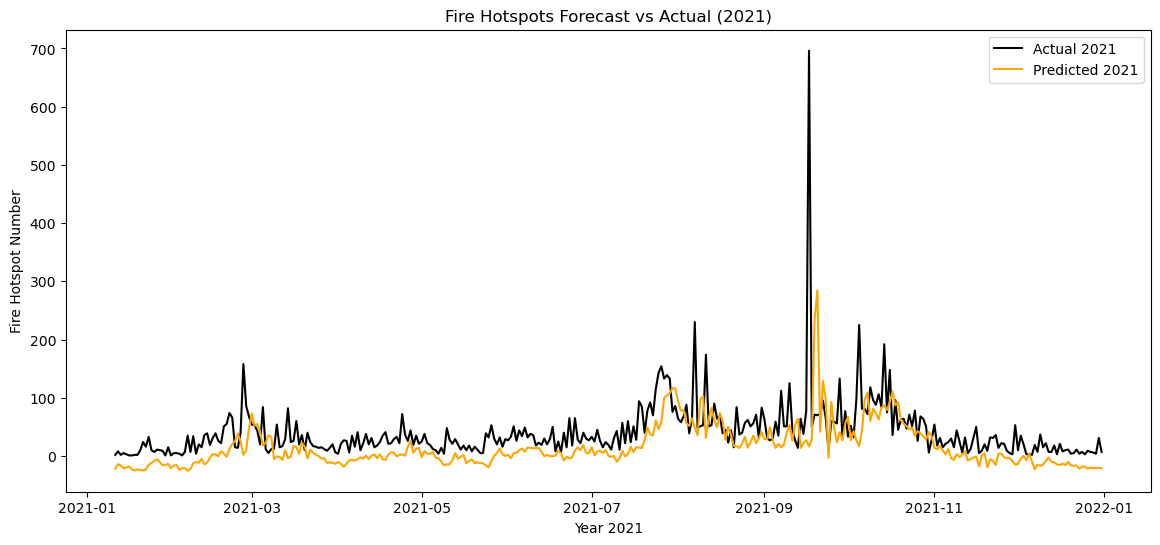

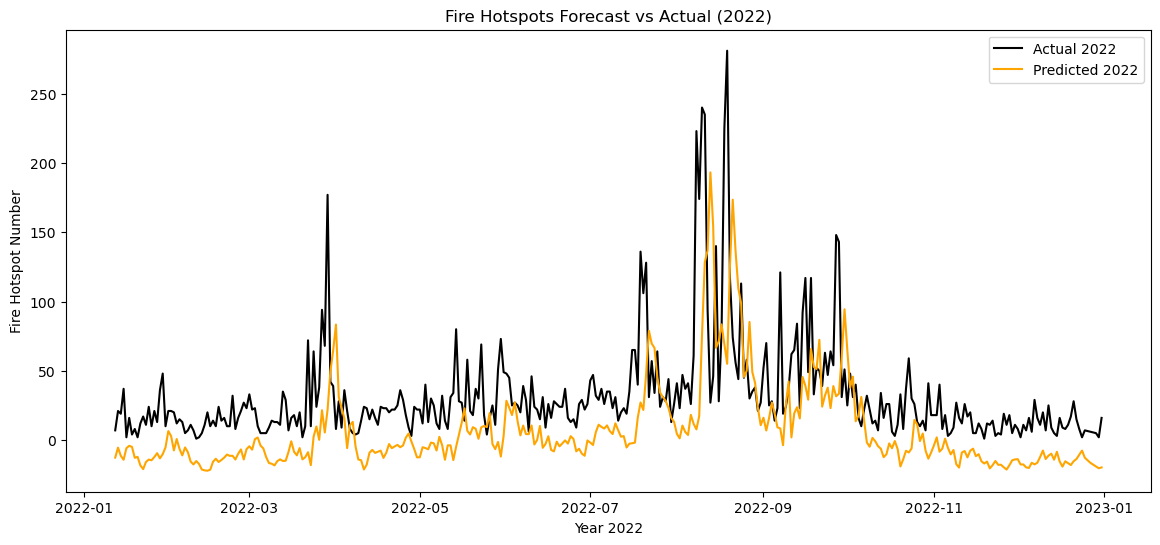

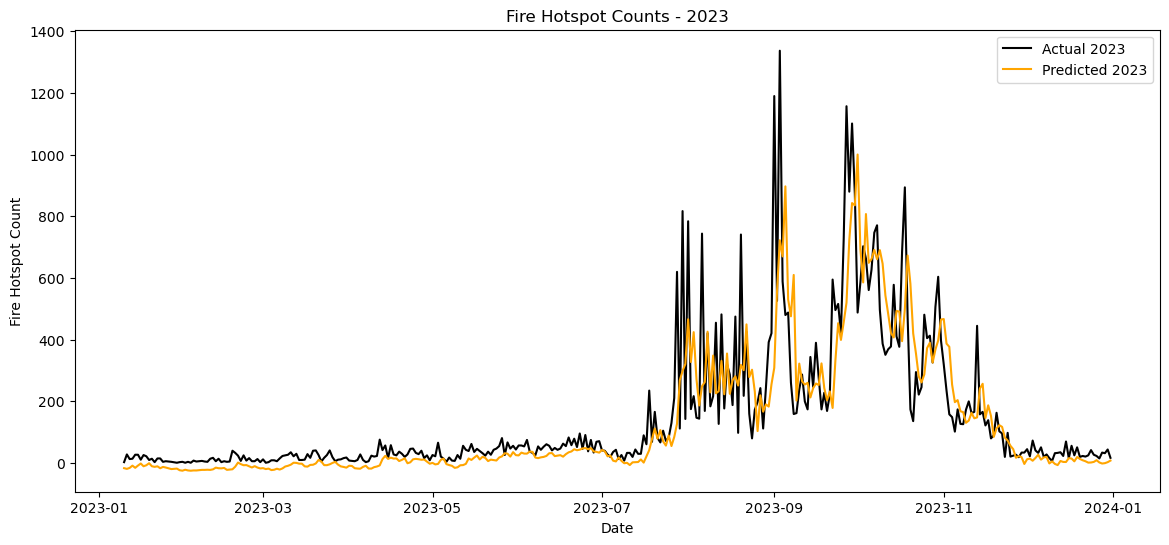

In [38]:
# Use the best parameters to retrain the final model
best_params = study.best_params

# Final model training with optimal parameters
time_step = best_params["time_step"]
X_train, y_train = create_sequences(train_scaled, time_step)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

input_layer = Input(shape=(time_step, 1))
lstm_out = LSTM(best_params["lstm_units"], return_sequences=True)(input_layer)
dropout_1 = Dropout(best_params["dropout_rate"])(lstm_out)
attention_out = attention_block(dropout_1)
lstm_out_2 = LSTM(best_params["lstm_units"], return_sequences=False)(attention_out)
dropout_2 = Dropout(best_params["dropout_rate"])(lstm_out_2)
dense_1 = Dense(50)(dropout_2)
output = Dense(1)(dense_1)

final_model = Model(inputs=input_layer, outputs=output)
final_model.compile(optimizer='adam', loss='mean_squared_error')

final_model.fit(X_train, y_train, epochs=best_params["epochs"], batch_size=best_params["batch_size"], verbose=1)


# Test data prediction for 2021 and 2022 and 2023
test_scaled_2021 = scaler.transform(test_data_2021[['fire_hotspot_count']].values)
test_scaled_2022 = scaler.transform(test_data_2022[['fire_hotspot_count']].values)
test_scaled_2023 = scaler.transform(test_data_2023[['fire_hotspot_count']].values)


X_test_2021, y_test_2021 = create_sequences(test_scaled_2021, time_step)
X_test_2022, y_test_2022 = create_sequences(test_scaled_2022, time_step)
X_test_2023, y_test_2023 = create_sequences(test_scaled_2023, time_step)


X_test_2021 = X_test_2021.reshape(X_test_2021.shape[0], X_test_2021.shape[1], 1)
X_test_2022 = X_test_2022.reshape(X_test_2022.shape[0], X_test_2022.shape[1], 1)
X_test_2023 = X_test_2023.reshape(X_test_2023.shape[0], X_test_2023.shape[1], 1)


predicted_2021 = final_model.predict(X_test_2021)
predicted_2022 = final_model.predict(X_test_2022)
predicted_2023 = final_model.predict(X_test_2023)


predicted_2021_unscaled = scaler.inverse_transform(predicted_2021)
predicted_2022_unscaled = scaler.inverse_transform(predicted_2022)
predicted_2023_unscaled = scaler.inverse_transform(predicted_2023)


# Visualization
test_days_2021 = test_data_2021.iloc[time_step + 1:]['acq_date']
test_days_2022 = test_data_2022.iloc[time_step + 1:]['acq_date']
test_days_2023 = test_data_2023.iloc[time_step + 1:]['acq_date']


# Plot actual vs predicted fire hotspot numbers for 2021
plt.figure(figsize=(14, 6))
plt.plot(test_days_2021, test_data_2021['fire_hotspot_count'][time_step + 1:], label='Actual 2021', color='black')
plt.plot(test_days_2021, predicted_2021_unscaled, label='Predicted 2021', color='orange')
plt.title('Fire Hotspots Forecast vs Actual (2021)')
plt.xlabel('Year 2021')
plt.ylabel('Fire Hotspot Number')
plt.legend()
plt.show()

# Plot actual vs predicted fire hotspot numbers for 2022
plt.figure(figsize=(14, 6))
plt.plot(test_days_2022, test_data_2022['fire_hotspot_count'][time_step + 1:], label='Actual 2022', color='black')
plt.plot(test_days_2022, predicted_2022_unscaled, label='Predicted 2022', color='orange')
plt.title('Fire Hotspots Forecast vs Actual (2022)')
plt.xlabel('Year 2022')
plt.ylabel('Fire Hotspot Number')
plt.legend()
plt.show()

# Plot actual vs predicted fire hotspot numbers for 2023
plt.figure(figsize=(14, 6))
plt.plot(test_days_2023, scaler.inverse_transform(y_test_2023.reshape(-1, 1)), label='Actual 2023',  color='black')
plt.plot(test_days_2023, predicted_2023_unscaled, label='Predicted 2023', color='orange')
plt.title('Fire Hotspot Counts - 2023')
plt.xlabel('Date')
plt.ylabel('Fire Hotspot Count')
plt.legend()
plt.show()


In [39]:

# Calculate RMSE for 2021
rmse_2021_LSTMA = np.sqrt(mean_squared_error(test_data_2021['fire_hotspot_count'][time_step + 1:], predicted_2021_unscaled))
print(f"RMSE for 2021: {rmse_2021_LSTMA}")

# Calculate RMSE for 2022
rmse_2022_LSTMA = np.sqrt(mean_squared_error(test_data_2022['fire_hotspot_count'][time_step + 1:], predicted_2022_unscaled))
print(f"RMSE for 2022: {rmse_2022_LSTMA}")

# Calculate RMSE for 2023
rmse_2023_LSTMA = np.sqrt(mean_squared_error(test_data_2023['fire_hotspot_count'][time_step + 1:], predicted_2023_unscaled))
print(f"RMSE for 2023: {rmse_2023_LSTMA}")


RMSE for 2021: 54.26479881827898
RMSE for 2022: 42.77910179744795
RMSE for 2023: 147.89458539468112


# Time Series Transformer

In [25]:
# Define the TimeSeriesDataset class
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)

# Define the Transformer model for time series

# Additive Attention Layer for Decoder
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.energy_proj = nn.Linear(hidden_dim, 1)  # To compute the attention scores

    def forward(self, query, key, value):
        # query, key, value: (batch_size, seq_length, hidden_dim)
        
        # Project the query and key to compute energy
        query = self.query_proj(query)  # Shape: (batch_size, seq_length, hidden_dim)
        key = self.key_proj(key)        # Shape: (batch_size, seq_length, hidden_dim)
        
        # Compute energy using additive attention
        energy = torch.tanh(query.unsqueeze(2) + key.unsqueeze(1))  # Shape: (batch_size, seq_length, seq_length, hidden_dim)
        energy = self.energy_proj(energy)  # Shape: (batch_size, seq_length, seq_length, 1)
        
        attention_scores = energy.squeeze(-1)  # Shape: (batch_size, seq_length, seq_length)
        attention_weights = torch.softmax(attention_scores, dim=-1)  # Softmax over the key dimension
        
        # Apply attention to the value
        output = torch.bmm(attention_weights, value)  # Shape: (batch_size, seq_length, hidden_dim)
        
        return output
    
class TimeSeriesTransformerWithAdditiveAttention(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim, num_heads=2, num_encoder_layers=2, num_decoder_layers=2, dropout=0.1):
        super(TimeSeriesTransformerWithAdditiveAttention, self).__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)  # Input embedding
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.additive_attention = AdditiveAttention(hidden_dim)
        self.decoder_ff = nn.Linear(hidden_dim, hidden_dim)  # Feedforward layer in decoder
        
        # Use Softplus to ensure non-negative output
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * seq_length, 1),
            nn.Softplus()  # Ensures predictions >= 0 with smooth transitions
        )
        
    def forward(self, x):
        x = self.embedding(x)
        memory = self.transformer_encoder(x)
        output = self.additive_attention(x, memory, memory)
        output = self.decoder_ff(output)
        output = output.view(output.size(0), -1)
        return self.regressor(output)

# Define the objective function for Optuna
def objective(trial):
    # Hyperparameters to tune
    num_heads = trial.suggest_int('num_heads', 1, 4)
    num_encoder_layers = trial.suggest_int('num_encoder_layers', 1, 4)
    num_decoder_layers = trial.suggest_int('num_decoder_layers', 1, 4)
    dropout = trial.suggest_float('dropout', 0.1, 0.5)
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    # Ensure hidden_dim is divisible by num_heads
    hidden_dim = num_heads * 8  

    # Create sequences for training
    def create_sequences(data, time_step=2):
        X, y = [], []
        for i in range(len(data) - time_step - 1):
            X.append(data[i:(i + time_step), 0])
            y.append(data[i + time_step, 0])
        return np.array(X), np.array(y)

    time_step = 2
    X_train, y_train = create_sequences(train_scaled, time_step)
    train_dataset = TimeSeriesDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define the model with trial parameters
    model = TimeSeriesTransformerWithAdditiveAttention(input_dim=1, seq_length=time_step, hidden_dim=hidden_dim, num_heads=num_heads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dropout=dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    model.train()
    for epoch in range(5):  # Use a few epochs for tuning to save time
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            predictions = model(X_batch.unsqueeze(2))  # Add feature dimension
            loss = criterion(predictions.squeeze(), y_batch)
            loss.backward()
            optimizer.step()

    # Calculate RMSE on the training data to evaluate performance
    model.eval()
    with torch.no_grad():
        predictions = []
        actuals = []
        for X_batch, y_batch in train_loader:
            preds = model(X_batch.unsqueeze(2)).squeeze().numpy()
            predictions.extend(preds)
            actuals.extend(y_batch.numpy())

    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    return rmse

# Run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50) 

# Print the best hyperparameters
print("Best hyperparameters:", study.best_params)
print("Best RMSE:", study.best_value)


[I 2024-11-29 18:46:13,222] A new study created in memory with name: no-name-d7c6ae28-a579-4af9-9d4b-9bf99a5a2d4d
C:\Users\tinku\AppData\Local\Temp\ipykernel_9580\2534418304.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2024-11-29 18:46:29,974] Trial 0 finished with value: 0.04520589858293533 and parameters: {'num_heads': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.48442855130016593, 'lr': 0.0007357838766738782, 'batch_size': 32}. Best is trial 0 with value: 0.04520589858293533.
C:\Users\tinku\AppData\Local\Temp\ipykernel_9580\2534418304.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l

[I 2024-11-29 18:50:58,517] Trial 13 finished with value: 0.04107740521430969 and parameters: {'num_heads': 4, 'num_encoder_layers': 1, 'num_decoder_layers': 1, 'dropout': 0.33455542567119356, 'lr': 0.00025225366271225294, 'batch_size': 16}. Best is trial 13 with value: 0.04107740521430969.
C:\Users\tinku\AppData\Local\Temp\ipykernel_9580\2534418304.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2024-11-29 18:51:18,937] Trial 14 finished with value: 0.04504891112446785 and parameters: {'num_heads': 3, 'num_encoder_layers': 3, 'num_decoder_layers': 2, 'dropout': 0.33968110509861266, 'lr': 0.00032251309048887715, 'batch_size': 32}. Best is trial 13 with value: 0.04107740521430969.
C:\Users\tinku\AppData\Local\Temp\ipykernel_9580\2534418304.py:74: FutureWarning: suggest_logu

C:\Users\tinku\AppData\Local\Temp\ipykernel_9580\2534418304.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2024-11-29 18:54:39,760] Trial 27 finished with value: 0.04008321836590767 and parameters: {'num_heads': 4, 'num_encoder_layers': 1, 'num_decoder_layers': 1, 'dropout': 0.1631265702717808, 'lr': 0.00040894174909981865, 'batch_size': 32}. Best is trial 17 with value: 0.038835179060697556.
C:\Users\tinku\AppData\Local\Temp\ipykernel_9580\2534418304.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2024-11-29 18:55:02,867] Trial 28 finished with value: 0.0417

[I 2024-11-29 18:57:35,233] Trial 40 finished with value: 0.04038339853286743 and parameters: {'num_heads': 2, 'num_encoder_layers': 2, 'num_decoder_layers': 3, 'dropout': 0.23571006181522072, 'lr': 0.000783274057320604, 'batch_size': 64}. Best is trial 39 with value: 0.038537707179784775.
C:\Users\tinku\AppData\Local\Temp\ipykernel_9580\2534418304.py:74: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-3)
[I 2024-11-29 18:57:45,722] Trial 41 finished with value: 0.03972141072154045 and parameters: {'num_heads': 3, 'num_encoder_layers': 1, 'num_decoder_layers': 3, 'dropout': 0.3095868797906599, 'lr': 0.0006160436189084808, 'batch_size': 32}. Best is trial 39 with value: 0.038537707179784775.
C:\Users\tinku\AppData\Local\Temp\ipykernel_9580\2534418304.py:74: FutureWarning: suggest_loguni

Best hyperparameters: {'num_heads': 3, 'num_encoder_layers': 1, 'num_decoder_layers': 3, 'dropout': 0.22523412151262667, 'lr': 0.0007677697321045236, 'batch_size': 32}
Best RMSE: 0.038537707179784775


Epoch 1, Loss: 0.00045621703611686826
Epoch 2, Loss: 0.0006393384537659585
Epoch 3, Loss: 9.039690485224128e-05
Epoch 4, Loss: 0.0007194457575678825
Epoch 5, Loss: 0.0011203493922948837


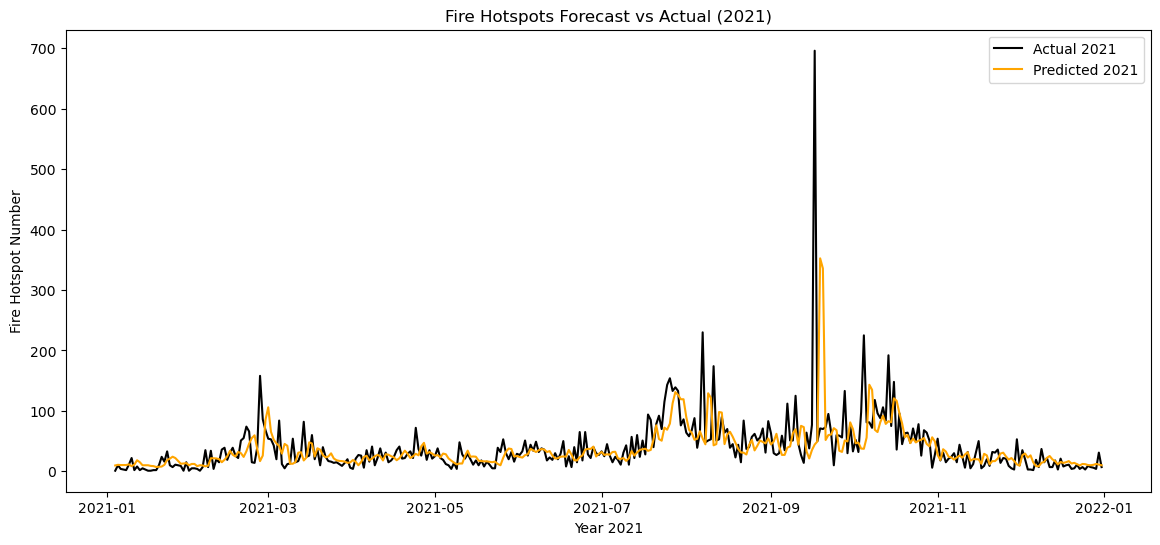

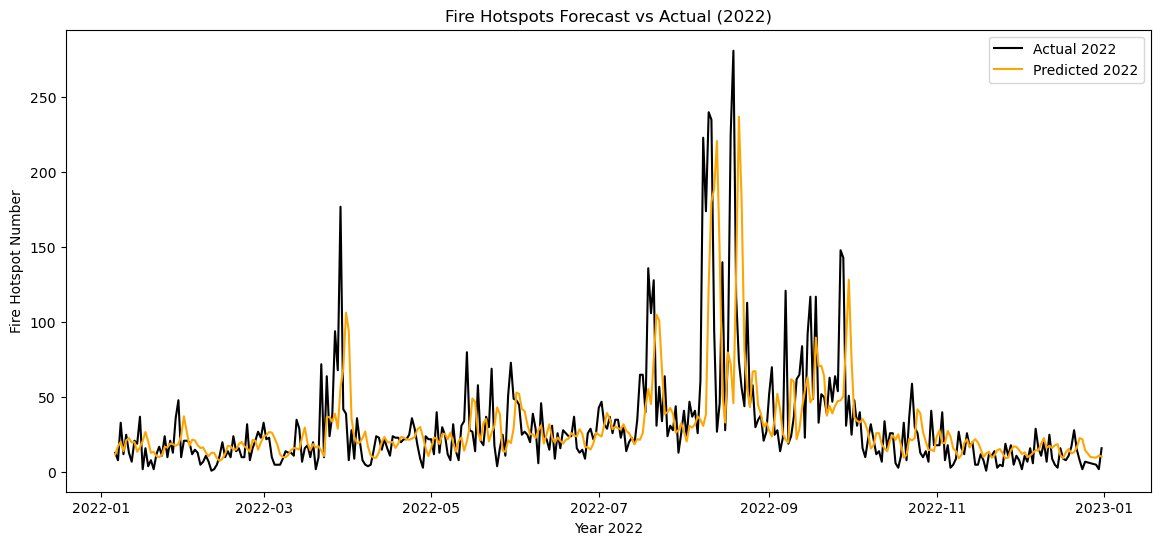

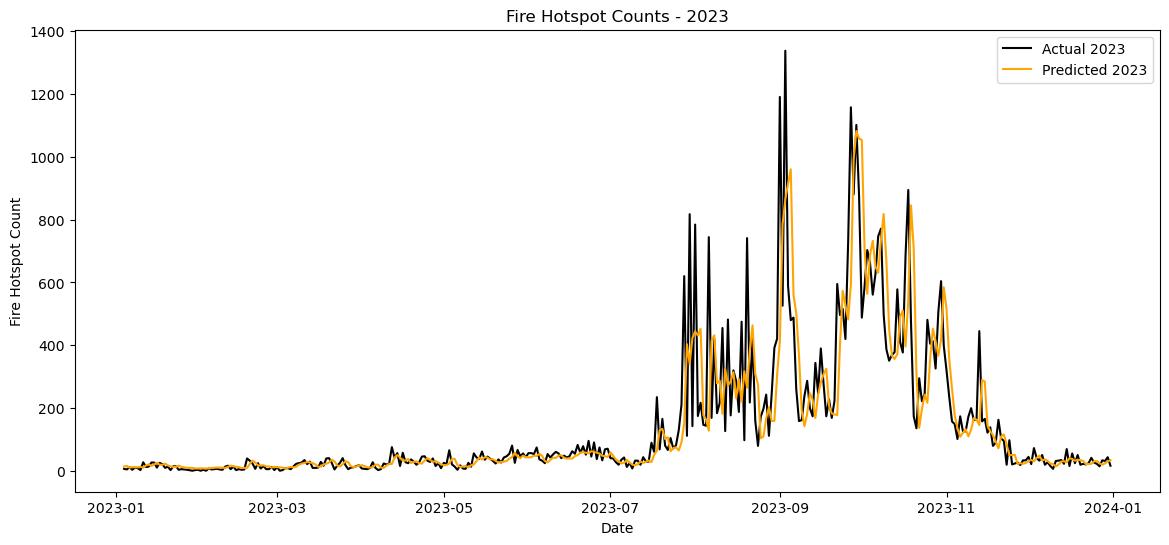

In [26]:
# Set random seeds for reproducibility
np.random.seed(43)
torch.manual_seed(43)


# Custom dataset class for time-series data
class TimeSeriesDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.float32)



# Create sequences
def create_sequences(data, time_step=2):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 2
X_train, y_train = create_sequences(train_scaled, time_step)
train_dataset = TimeSeriesDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)  # Keep shuffle=True for training

# Additive Attention Layer for Decoder
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim):
        super(AdditiveAttention, self).__init__()
        self.query_proj = nn.Linear(hidden_dim, hidden_dim)
        self.key_proj = nn.Linear(hidden_dim, hidden_dim)
        self.energy_proj = nn.Linear(hidden_dim, 1)  # To compute the attention scores

    def forward(self, query, key, value):
        # query, key, value: (batch_size, seq_length, hidden_dim)
        
        # Project the query and key to compute energy
        query = self.query_proj(query)  # Shape: (batch_size, seq_length, hidden_dim)
        key = self.key_proj(key)        # Shape: (batch_size, seq_length, hidden_dim)
        
        # Compute energy using additive attention
        energy = torch.tanh(query.unsqueeze(2) + key.unsqueeze(1))  # Shape: (batch_size, seq_length, seq_length, hidden_dim)
        energy = self.energy_proj(energy)  # Shape: (batch_size, seq_length, seq_length, 1)
        
        attention_scores = energy.squeeze(-1)  # Shape: (batch_size, seq_length, seq_length)
        attention_weights = torch.softmax(attention_scores, dim=-1)  # Softmax over the key dimension
        
        # Apply attention to the value
        output = torch.bmm(attention_weights, value)  # Shape: (batch_size, seq_length, hidden_dim)
        
        return output

class TimeSeriesTransformerWithSoftplus(nn.Module):
    def __init__(self, input_dim, seq_length, hidden_dim=50, num_heads=2, num_encoder_layers=2, dropout=0.129560676270903):
        super(TimeSeriesTransformerWithSoftplus, self).__init__()
        
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=num_heads, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        
        self.additive_attention = AdditiveAttention(hidden_dim)
        self.decoder_ff = nn.Linear(hidden_dim, hidden_dim)
        
        # Use Softplus for a smooth non-negative output
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * seq_length, 1),
        )
        
    def forward(self, x):
        x = self.embedding(x)
        memory = self.transformer_encoder(x)
        output = self.additive_attention(x, memory, memory)
        output = self.decoder_ff(output)
        output = output.view(output.size(0), -1)
        return self.regressor(output)



# Initialize model, loss, and optimizer
model = TimeSeriesTransformerWithSoftplus(input_dim=1, seq_length=time_step)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00013412583256255093)

# Training loop with controlled randomness
model.train()
for epoch in range(5):  # Training for 5 epochs
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        predictions = model(X_batch.unsqueeze(2))  # Add feature dimension
        loss = criterion(predictions.squeeze(), y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")

# Prepare test data
test_scaled_2021 = scaler.transform(test_data_2021[['fire_hotspot_count']].values)
test_scaled_2022 = scaler.transform(test_data_2022[['fire_hotspot_count']].values)
test_scaled_2023 = scaler.transform(test_data_2023[['fire_hotspot_count']].values)

X_test_2021, y_test_2021 = create_sequences(test_scaled_2021, time_step)
X_test_2022, y_test_2022 = create_sequences(test_scaled_2022, time_step)
X_test_2023, y_test_2023 = create_sequences(test_scaled_2023, time_step)

X_test_2021 = torch.tensor(X_test_2021, dtype=torch.float32)
X_test_2022 = torch.tensor(X_test_2022, dtype=torch.float32)
X_test_2023 = torch.tensor(X_test_2023, dtype=torch.float32)


# Prediction and Evaluation
model.eval()
with torch.no_grad():
    predictions_2021 = model(X_test_2021.unsqueeze(2)).numpy()  # Ensure correct shape without squeezing
    predictions_2022 = model(X_test_2022.unsqueeze(2)).numpy()  # Ensure correct shape without squeezing
    predictions_2023 = model(X_test_2023.unsqueeze(2)).numpy()  # Ensure correct shape without squeezing


# Inverse transform predictions for original scale
predicted_2021_unscaled = scaler.inverse_transform(predictions_2021.reshape(-1, 1))
predicted_2022_unscaled = scaler.inverse_transform(predictions_2022.reshape(-1, 1))
predicted_2023_unscaled = scaler.inverse_transform(predictions_2023.reshape(-1, 1))

# Plot actual vs predicted fire hotspot numbers for 2021
test_days_2021 = test_data_2021.iloc[time_step + 1:]['acq_date']
plt.figure(figsize=(14, 6))
plt.plot(test_days_2021, test_data_2021['fire_hotspot_count'][time_step + 1:], label='Actual 2021', color='black')
plt.plot(test_days_2021, predicted_2021_unscaled, label='Predicted 2021', color='orange')
plt.title('Fire Hotspots Forecast vs Actual (2021)')
plt.xlabel('Year 2021')
plt.ylabel('Fire Hotspot Number')
plt.legend()
plt.show()

# Plot actual vs predicted fire hotspot numbers for 2022
test_days_2022 = test_data_2022.iloc[time_step + 1:]['acq_date']
plt.figure(figsize=(14, 6))
plt.plot(test_days_2022, test_data_2022['fire_hotspot_count'][time_step + 1:], label='Actual 2022', color='black')
plt.plot(test_days_2022, predicted_2022_unscaled, label='Predicted 2022', color='orange')
plt.title('Fire Hotspots Forecast vs Actual (2022)')
plt.xlabel('Year 2022')
plt.ylabel('Fire Hotspot Number')
plt.legend()
plt.show()

# Plot actual vs predicted fire hotspot numbers for 2023
test_days_2023 = test_data_2023.iloc[time_step + 1:]['acq_date']
plt.figure(figsize=(14, 6))
plt.plot(test_days_2023, scaler.inverse_transform(y_test_2023.reshape(-1, 1)), label='Actual 2023',  color='black')
plt.plot(test_days_2023, predicted_2023_unscaled, label='Predicted 2023', color='orange')
plt.title('Fire Hotspot Counts - 2023')
plt.xlabel('Date')
plt.ylabel('Fire Hotspot Count')
plt.legend()
plt.show()


In [27]:
# Calculate RMSE for 2021
rmse_2021_transformer = np.sqrt(mean_squared_error(test_data_2021['fire_hotspot_count'][time_step + 1:], predicted_2021_unscaled))
print(f"RMSE for 2021: {rmse_2021_transformer}")

# Calculate RMSE for 2022
rmse_2022_transformer = np.sqrt(mean_squared_error(test_data_2022['fire_hotspot_count'][time_step + 1:], predicted_2022_unscaled))
print(f"RMSE for 2022: {rmse_2022_transformer}")

# Calculate RMSE for 2023
rmse_2023_transformer = np.sqrt(mean_squared_error(test_data_2023['fire_hotspot_count'][time_step + 1:], predicted_2023_unscaled))
print(f"RMSE for 2023: {rmse_2023_transformer}")


RMSE for 2021: 49.18149165300974
RMSE for 2022: 34.78049898978641
RMSE for 2023: 144.24573719092797


In [28]:
from scipy.stats import ttest_rel

# RMSE for LSTM and Transformer on multiple test runs
lstm_rmse = [rmse_2021_LSTM, rmse_2022_LSTM, rmse_2023_LSTM]  
transformer_rmse = [rmse_2021_transformer, rmse_2022_transformer, rmse_2023_transformer]  

# paired t-test
stat, p_value = ttest_rel(lstm_rmse, transformer_rmse)
print(f"Paired t-test p-value: {p_value}")

if p_value < 0.05:
    print("The difference in performance is statistically significant.")
else:
    print("The difference in performance is not statistically significant.")


Paired t-test p-value: 0.3535072797186294
The difference in performance is not statistically significant.


In [30]:
from scipy.stats import chi2
import numpy as np

# RMSE values for models 
rmse_lstm = rmse_2021_LSTM, rmse_2022_LSTM, rmse_2023_LSTM  
rmse_transformer = rmse_2021_transformer, rmse_2022_transformer, rmse_2023_transformer

# Define total sum of squared errors for each model
sse_lstm = np.sum([rmse ** 2 for rmse in rmse_lstm])
sse_transformer = np.sum([rmse ** 2 for rmse in rmse_transformer])

# Calculate the likelihoods for each model
likelihood_lstm = -0.5 * np.sum(np.log(sse_lstm))
likelihood_transformer = -0.5 * np.sum(np.log(sse_transformer))

# Calculate the G-test statistic
g_statistic = -2 * (likelihood_lstm - likelihood_transformer)

# Degrees of freedom: number of models - 1
df = 2  # Comparing three models

# Compute the p-value
p_value = chi2.sf(g_statistic, df)

# Display results
print(f"G-Statistic: {g_statistic}")
print(f"Degrees of Freedom: {df}")
print(f"P-Value: {p_value}")

# Conclusion
if p_value < 0.05:
    print("Significant difference detected between models. Reject the null hypothesis.")
else:
    print("No significant difference detected between models. Fail to reject the null hypothesis.")


G-Statistic: 0.024473459818540988
Degrees of Freedom: 2
P-Value: 0.9878378344190955
No significant difference detected between models. Fail to reject the null hypothesis.
